In [1]:
import sys
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_theme(style="white")

# Copy Number Variation Insights

The objective of this notebook is to map copy number variation (CNV) information to the GDSC database. In folder `knowledge_base/table_contents.md` it is described from where the CNV and GDSC data is originating from. In the previous notebook `02_GDSC_map_GenExpr.ipynb` we mapped the GDSC data to gene-expression information. The resulting table is saved in `temp_datasets/joined_gdsc_geneexpr.pkl` which will be the starting point for this notebook.

In [3]:
!pwd
!find ../../datasets/gdsc/cell_line_genomic_data -name '*cnv*.csv' -ls

/Users/cwoest/Documents/Academics/Data_Science_UP/master_thesis/material/GNN-material
37667852   189544 -rw-------    1 cwoest           staff            97043230 Nov  1  2019 ../../datasets/gdsc/cell_line_genomic_data/cnv_abs_copy_number_picnic_20191101.csv
37667853   169408 -rw-------    1 cwoest           staff            86734917 Nov  1  2019 ../../datasets/gdsc/cell_line_genomic_data/cnv_gistic_20191101.csv


The files we will use for mapping are
- `cnv_abs_copy_number_picnic_20191101.csv`
- `cnv_gistic_20191101.csv`

In [2]:
PATH_TO_CNV_DATA = '../../datasets/gdsc/cell_line_genomic_data/'
PATH_TO_SAVE_DATA_TO = '../../datasets/gdsc/my_datasets/'

CNV_PICNIC = 'cnv_abs_copy_number_picnic_20191101.csv'
CNV_GISTIC = 'cnv_gistic_20191101.csv'

In [5]:
# First, we load the GDSC dataset from the previous notebook.
GDSC = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}joined_gdsc_geneexpr.pkl')
print(GDSC.shape)
GDSC.head(3)

(446521, 922)


,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,...,8.355826,8.951680,7.205590,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,...,5.995760,9.337588,7.468226,3.716270,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,...,6.939741,8.688176,7.085349,3.688222,4.572119,6.345090,12.276166,4.114092,5.768098,7.505155


--- 

## CNV PICNIC

In this subsection we will investigate and potentially map the `cnv_abs_copy_number_picnic_20191101.csv` content to the `GDSC` dataset.

In [6]:
CNV_PICNIC

'cnv_abs_copy_number_picnic_20191101.csv'

In [7]:
start = time.time()
cnv_picnic_data = pd.read_csv(f'{PATH_TO_CNV_DATA}{CNV_PICNIC}', sep=",", header=1)
print(f"File `{CNV_PICNIC}` took {time.time()-start:.5f} seconds to import. \nShape: {cnv_picnic_data.shape}")
cnv_picnic_data.head(3)

File `cnv_abs_copy_number_picnic_20191101.csv` took 2.47200 seconds to import. 
Shape: (24503, 988)


,model_name,Unnamed: 1,M14,TE-12,TMK-1,STS-0421,PL4,PCI-4B,PCI-30,HSC-39,...,451Lu,MMAc-SF,BE-13,MC-IXC,Ramos-2G6-4C10,CGTH-W-1,H9,GR-ST,YMB-1-E,MM1S
0,gene_id,symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SIDG00001,A1BG,3.0,3.0,3.0,4.0,6.0,3.0,2.0,3.0,...,4.0,3.0,4.0,2.0,2.0,4.0,4.0,2.0,3.0,2.0
2,SIDG00003,A1CF,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,...,4.0,2.0,3.0,1.0,2.0,3.0,4.0,2.0,3.0,2.0


In [8]:
l = []
for c in GDSC.CELL_LINE_NAME.values: 
    if c in cnv_picnic_data.columns:
        l.append(c)
print(len(l))

441777


In [9]:
l = []
for c in GDSC.columns: 
    if c in cnv_picnic_data['Unnamed: 1'].values:
        l.append(c)
print(len(l))

900


`cnv_picnic_data` contains 
- As columns `CELL_LINES_NAMES`
- Under column `Unnamed: 1` the gene symbols which are columns of the `GDSC` dataset.

A little tweaking needs to be done to clean the `cnv_picnic_data` dataset.

In [10]:
cnv_picnic_data_v2 = cnv_picnic_data.copy()
# Cleaner names.
cnv_picnic_data_v2.rename(columns={
    'Unnamed: 1': 'GENE_SYMBOL',
    'model_name': 'GENE_ID'}, inplace=True)
# Drop 1st row.
cnv_picnic_data_v2 = cnv_picnic_data_v2.iloc[1:, :]
print(cnv_picnic_data_v2.shape)
cnv_picnic_data_v2.head(3)

(24502, 988)


,GENE_ID,GENE_SYMBOL,M14,TE-12,TMK-1,STS-0421,PL4,PCI-4B,PCI-30,HSC-39,...,451Lu,MMAc-SF,BE-13,MC-IXC,Ramos-2G6-4C10,CGTH-W-1,H9,GR-ST,YMB-1-E,MM1S
1,SIDG00001,A1BG,3.0,3.0,3.0,4.0,6.0,3.0,2.0,3.0,...,4.0,3.0,4.0,2.0,2.0,4.0,4.0,2.0,3.0,2.0
2,SIDG00003,A1CF,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,...,4.0,2.0,3.0,1.0,2.0,3.0,4.0,2.0,3.0,2.0
3,SIDG00004,A2M,3.0,3.0,2.0,4.0,9.0,3.0,3.0,3.0,...,5.0,3.0,4.0,2.0,2.0,4.0,3.0,2.0,5.0,2.0


`cnv_picnic_data_v2`: 
- Dimension: n_GENE_SYMBOLs x (2 + n_CELL_LINE_NAMEs)

In [11]:
# How many of the 986 (=988-2) CELL_LINE_NAME's in cnv_picnic_data_v2 are also in the GDSC dataset?
cnv_cell_line_names = list(np.unique(cnv_picnic_data_v2.iloc[:, 2:].columns))
gdsc_cell_line_names = list(np.unique(GDSC.CELL_LINE_NAME.values))

print(f"""CELL_LINE_NAME insights:
    CNV PICNIC has {len(cnv_cell_line_names):6.0f}  unique cell line names as columns.
    GDSC       has {len(gdsc_cell_line_names):6.0f} unique cell lines names under the column CELL_LINE_NAME.
""")

# How many of the genes (GENE_SYMBOL) in cnv_picnic_data_v2 are also in the GDSC dataset?
cnv_gene_symbols = list(np.unique(cnv_picnic_data_v2.GENE_SYMBOL.values))
gdsc_gene_symbols = list(np.unique(GDSC.iloc[:, 14:].columns))

print(f"""GENE_SYMBOL insights:
    CNV PICNIC has {len(cnv_gene_symbols):6.0f}  unique gene symbols under the column GENE_SYMBOL.
    GDSC       has {len(gdsc_gene_symbols):6.0f} unique gene_symbols as columns.
""")

CELL_LINE_NAME insights:
    CNV PICNIC has    986  unique cell line names as columns.
    GDSC       has    988 unique cell lines names under the column CELL_LINE_NAME.

GENE_SYMBOL insights:
    CNV PICNIC has  24502  unique gene symbols under the column GENE_SYMBOL.
    GDSC       has    908 unique gene_symbols as columns.



If we are adding again more then 900 columns now to the GDSC table, these columns will also be `GENE_SYMBOL` column, just with different information per cell, namely copy number variations per cell instead of gene expressions as before (see previous notebook). Due to that reason we will now create a new GDSC dataframe. Then, in future steps, we add all dataframes on top to create a tensor with `CELL_LINE_NAME x GENE_SYMBOL x FEATURE_INFORMATION`, where `FEATURE_INFORMATION` can be gene expression, copy number variation or mutation information.

In [12]:
# Ignore the GENE_SYMBOL columns from the GDSC dataset.
gdsc_base = GDSC.iloc[:, :14]
gdsc_base.head(3)

,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,DATASET,Z_SCORE,LN_IC50,DRUG_ID
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,GDSC1,-0.189576,2.395685,1
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,GDSC1,0.508635,3.140923,1
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,GDSC1,1.284229,3.968757,1


In [22]:
# Transpose the CNV table such that the GENE_SYMBOLs are the columns and the CELL_LINE_NAMES are the indexes of the rows.
# Copy CNV dataset without GENE_ID column and transpose.
cnv_picnic_data_v3 = cnv_picnic_data_v2.iloc[:, 1:].copy().T
# Ignore the first row and make the GEN_SYMBOL names as the new columns. Also make the previous CELL_LINE_NAMES columns as the new row index.
cnv_picnic_data_v3 = cnv_picnic_data_v3.rename(columns=cnv_picnic_data_v3.iloc[0]).drop(cnv_picnic_data_v3.index[0])
print(cnv_picnic_data_v3.shape)
cnv_picnic_data_v3.head(3)


(986, 24502)


,A1BG,A1CF,A2M,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,A4GNT,AAAS,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3
M14,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,...,3.0,2.0,2.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0
TE-12,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,...,3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
TMK-1,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,...,3.0,2.0,2.0,1.0,3.0,3.0,3.0,3.0,2.0,3.0


This dataset `cnv_picnic_data_v3` could now be added onto the `gdsc_base` to have the CNV values per cell-line and gene. However, over 24,000 columns (genes/gene symbols) is way too much. Analogous to the previous notebook we will sparse this feature space by using a list of landmark_genes. 

### Sparsing the Feature Space

Since the `cnv_picnic_data_v3` table holds $24,502$ genes (columns) we are trying to sparse down this set of columns by using _LINCS landmark gene symbols_.

- LINCS landmark gene symbols are in file `landmark_genes.csv`

In [23]:
FILENAME_LANDMARK_GENES = 'landmark_genes.csv' 

In [25]:
start = time.time()
landmark_genes = pd.read_csv(f'../../datasets/gdsc/{FILENAME_LANDMARK_GENES}', sep="\t")
print(f"File `{FILENAME_LANDMARK_GENES}` took {time.time()-start:.5f} seconds to import. It has shape {landmark_genes.shape}")
landmark_genes.head(3)

File `landmark_genes.csv` took 0.00743 seconds to import. It has shape (978, 7)


,Entrez ID,Symbol,Name,Gene Family,Type,RNA-Seq Correlation,RNA-Seq Correlation Self-Rank
0,3638,INSIG1,insulin induced gene 1,NaN,landmark,NaN,NaN
1,2309,FOXO3,forkhead box O3,Forkhead boxes,landmark,NaN,NaN
2,1001,CDH3,cadherin 3,Type I classical cadherins,landmark,NaN,NaN


In [27]:
cnv_picnic_data_v3.head(3)

,A1BG,A1CF,A2M,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,A4GNT,AAAS,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3
M14,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,...,3.0,2.0,2.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0
TE-12,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,...,3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
TMK-1,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,...,3.0,2.0,2.0,1.0,3.0,3.0,3.0,3.0,2.0,3.0


In [28]:
# Check how many cell line columns of the gene expressions table are in the landmark gene file.

count, cols_to_keep = 0, []
for c in cnv_picnic_data_v3.columns[cnv_picnic_data_v3.columns != 'nan']:
    if c in landmark_genes.Symbol.tolist(): 
        count += 1
        cols_to_keep.append(c)
        
print(f"""
    Out of {len(cnv_picnic_data_v3.columns[cnv_picnic_data_v3.columns != 'nan'])} non-nan columns in the gene expression file (`cnv_picnic_data_v3`) {count} columns are respresented  in the landmark_genes.csv file.
    Thus, {100*(1-count/len(cnv_picnic_data_v3.columns[cnv_picnic_data_v3.columns != 'nan'])):2.2f}% will get removed.
""")



    Out of 24502 non-nan columns in the gene expression file (`gene_expr`) 966 columns are respresented  in the landmark_genes.csv file.
    Thus, 96.06% will get removed.



Now we sparse down the columns in `cnv_picnic_data_v3` from $24,502$ to all the ones we found in the `landmark_genes.csv` file und the `Symbol` column. This leaves us with $966$ columns. The remaining $96.06% of all columns in `cnv_picnic_data_v3` will get removed. 

In [30]:
cnv_picnic_data_v4 = cnv_picnic_data_v3[cols_to_keep]
assert cnv_picnic_data_v4.shape[1] == len(cols_to_keep)
print(cnv_picnic_data_v4.shape)
cnv_picnic_data_v4.head(5)

(986, 966)


,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
M14,3.0,3.0,4.0,3.0,4.0,2.0,3.0,3.0,3.0,2.0,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0
TE-12,4.0,3.0,3.0,2.0,3.0,4.0,2.0,4.0,2.0,2.0,...,3.0,4.0,5.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0
TMK-1,3.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,...,2.0,2.0,5.0,3.0,3.0,2.0,3.0,3.0,2.0,4.0
STS-0421,4.0,3.0,5.0,3.0,5.0,4.0,4.0,3.0,4.0,3.0,...,5.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,3.0
PL4,4.0,6.0,6.0,5.0,6.0,6.0,2.0,4.0,5.0,3.0,...,4.0,8.0,6.0,6.0,5.0,4.0,5.0,6.0,4.0,5.0


__Summary__:
> `cnv_picnic_data_v4` - Cell lines as index column and genes as columns, where the genes got sparsed down by using landmark gene information.

### Map CNV Picnic Data to GDSC

In [31]:
print(gdsc_base.shape)
gdsc_base.head(3)

(446521, 14)


,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,DATASET,Z_SCORE,LN_IC50,DRUG_ID
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,GDSC1,-0.189576,2.395685,1
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,GDSC1,0.508635,3.140923,1
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,GDSC1,1.284229,3.968757,1


In [32]:
print(cnv_picnic_data_v4.shape)
cnv_picnic_data_v4.head(5)

(986, 966)


,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
M14,3.0,3.0,4.0,3.0,4.0,2.0,3.0,3.0,3.0,2.0,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0
TE-12,4.0,3.0,3.0,2.0,3.0,4.0,2.0,4.0,2.0,2.0,...,3.0,4.0,5.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0
TMK-1,3.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,...,2.0,2.0,5.0,3.0,3.0,2.0,3.0,3.0,2.0,4.0
STS-0421,4.0,3.0,5.0,3.0,5.0,4.0,4.0,3.0,4.0,3.0,...,5.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,3.0
PL4,4.0,6.0,6.0,5.0,6.0,6.0,2.0,4.0,5.0,3.0,...,4.0,8.0,6.0,6.0,5.0,4.0,5.0,6.0,4.0,5.0


In [33]:
col = 'CELL_LINE_NAME'

uniq_gdsc, uniq_cnv_picnic = np.unique(gdsc_base[col]), np.unique(cnv_picnic_data_v4.index)
print(f"""
    Number of unique {col}'s 
        in the GDSC db            : {len(uniq_gdsc)}
        in the CNV Picnic dataset : {len(uniq_cnv_picnic)}

    Number of cell-lines in the GDSC which are not in the CNV Picnic dataset: {len(set(uniq_gdsc) - set(uniq_cnv_picnic))}. 
    Thus, there will be no CNV information for these cell-lines.
""")


    Number of unique CELL_LINE_NAME's 
        in the GDSC db            : 988
        in the CNV Picnic dataset : 986

    Number of cell-lines in the GDSC which are not in the CNV Picnic dataset: 12. 
    Thus, there will be no CNV information for these cell-lines.



In [35]:
# Join the sparsed CNV data to the GDSC table.
cols_to_join_on = ['CELL_LINE_NAME']
join_gdsc_cnv_picnic = gdsc_base.merge(right       = cnv_picnic_data_v4,
                                       left_on     = cols_to_join_on,
                                       right_index = True,
                                       how         = 'left',
                                       suffixes    = ['_gdsc', '_cnv'])
print(join_gdsc_cnv_picnic.shape)
join_gdsc_cnv_picnic.head(3)

(446521, 980)


,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,...,1.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,...,2.0,3.0,3.0,3.0,4.0,6.0,4.0,3.0,4.0,3.0


- `join_gdsc_cnv_picnic` now contains the IC50 values for cell-line, drug combinations and in addition the copy number variation (CNV) values of the specific cell-line to multiple genes. 

In [43]:
# Save the GDSC table with the copy number variation information to a file.
join_gdsc_cnv_picnic.to_pickle(f'{PATH_TO_SAVE_DATA_TO}joined_gdsc_cnv_picnic.pkl')

--- 

## CNV GISTIC 

In this subsection we will investigate and potentially map the `cnv_gistic_20191101.csv` content to the `GDSC` dataset.

In [44]:
CNV_GISTIC

'cnv_gistic_20191101.csv'

In [45]:
# Download CNV Gistic dataset.
start = time.time()
cnv_gistic_data = pd.read_csv(f'{PATH_TO_CNV_DATA}{CNV_GISTIC}', sep=",", header=1)
print(f"File `{CNV_PICNIC}` took {time.time()-start:.5f} seconds to import. \nShape: {cnv_gistic_data.shape}")
cnv_gistic_data.head(3)

File `cnv_abs_copy_number_picnic_20191101.csv` took 3.13173 seconds to import. 
Shape: (20670, 980)


,model_name,Unnamed: 1,M14,TE-12,TMK-1,STS-0421,PL4,PCI-4B,PCI-30,HSC-39,...,451Lu,MMAc-SF,BE-13,MC-IXC,Ramos-2G6-4C10,CGTH-W-1,H9,GR-ST,YMB-1-E,MM1S
0,gene_id,symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SIDG00001,A1BG,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,-1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,SIDG00002,A1BG-AS1,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,-1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [47]:
cnv_gistic_data_v2 = cnv_gistic_data.copy()
# Cleaner names.
cnv_gistic_data_v2.rename(columns={
    'Unnamed: 1': 'GENE_SYMBOL',
    'model_name': 'GENE_ID'}, inplace=True)
# Drop 1st row.
cnv_gistic_data_v2 = cnv_gistic_data_v2.iloc[1:, :]
print(cnv_gistic_data_v2.shape)
cnv_gistic_data_v2.head(3)

(20669, 980)


,GENE_ID,GENE_SYMBOL,M14,TE-12,TMK-1,STS-0421,PL4,PCI-4B,PCI-30,HSC-39,...,451Lu,MMAc-SF,BE-13,MC-IXC,Ramos-2G6-4C10,CGTH-W-1,H9,GR-ST,YMB-1-E,MM1S
1,SIDG00001,A1BG,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,-1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,SIDG00002,A1BG-AS1,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,-1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,SIDG00003,A1CF,-1.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,...,0.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0


`cnv_gistic_data_v2`: 
- Dimension: n_GENE_SYMBOLs x (2 + n_CELL_LINE_NAMEs)

In [48]:
# How many of the 978 (=980-2) CELL_LINE_NAME's in cnv_gistic_data_v2 are also in the GDSC dataset?
cnv_gistic_cell_line_names = list(np.unique(cnv_gistic_data_v2.iloc[:, 2:].columns))
gdsc_cell_line_names = list(np.unique(GDSC.CELL_LINE_NAME.values))

print(f"""CELL_LINE_NAME insights:
    CNV GISTIC has {len(cnv_gistic_cell_line_names):6.0f}  unique cell line names as columns.
    GDSC       has {len(gdsc_cell_line_names):6.0f} unique cell lines names under the column CELL_LINE_NAME.
""")

# How many of the genes (GENE_SYMBOL) in cnv_gistic_data_v2 are also in the GDSC dataset?
cnv_gistic_gene_symbols = list(np.unique(cnv_gistic_data_v2.GENE_SYMBOL.values))
gdsc_gene_symbols = list(np.unique(GDSC.iloc[:, 14:].columns))

print(f"""GENE_SYMBOL insights:
    CNV GISTIC has {len(cnv_gistic_gene_symbols):6.0f}  unique gene symbols under the column GENE_SYMBOL.
    GDSC       has {len(gdsc_gene_symbols):6.0f} unique gene_symbols as columns.
""")

CELL_LINE_NAME insights:
    CNV GISTIC has    978  unique cell line names as columns.
    GDSC       has    988 unique cell lines names under the column CELL_LINE_NAME.

GENE_SYMBOL insights:
    CNV GISTIC has  20669  unique gene symbols under the column GENE_SYMBOL.
    GDSC       has    908 unique gene_symbols as columns.



In [49]:
# Ignore the GENE_SYMBOL columns from the GDSC dataset.
gdsc_base = GDSC.iloc[:, :14]
gdsc_base.head(3)

,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,DATASET,Z_SCORE,LN_IC50,DRUG_ID
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,GDSC1,-0.189576,2.395685,1
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,GDSC1,0.508635,3.140923,1
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,GDSC1,1.284229,3.968757,1


In [50]:
# Transpose the CNV table such that the GENE_SYMBOLs are the columns and the CELL_LINE_NAMES are the indexes of the rows.
# Copy CNV dataset without GENE_ID column and transpose.
cnv_gistic_data_v3 = cnv_gistic_data_v2.iloc[:, 1:].copy().T
# Ignore the first row and make the GEN_SYMBOL names as the new columns. Also make the previous CELL_LINE_NAMES columns as the new row index.
cnv_gistic_data_v3 = cnv_gistic_data_v3.rename(columns=cnv_gistic_data_v3.iloc[0]).drop(cnv_gistic_data_v3.index[0])
print(cnv_gistic_data_v3.shape)
cnv_gistic_data_v3.head(3)


(978, 20669)


,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
M14,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,-1.0,0.0,1.0,-1.0,1.0,1.0,1.0,2.0,2.0,2.0
TE-12,-1.0,-1.0,0.0,1.0,1.0,1.0,-1.0,0.0,0.0,0.0,...,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
TMK-1,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,-1.0,1.0,0.0,1.0,-2.0,0.0,0.0,2.0,-1.0,1.0


This dataset `cnv_gistic_data_v3` could now be added onto the `gdsc_base` to have the CNV values per cell-line and gene. However, over 20,000 columns (genes/gene symbols) is way too much. Analogous to the previous notebook and to the procedure we did for CNV Picnic we will sparse this feature space by using a list of landmark_genes. 

In [51]:
FILENAME_LANDMARK_GENES = 'landmark_genes.csv' 

In [52]:
start = time.time()
landmark_genes = pd.read_csv(f'../../datasets/gdsc/{FILENAME_LANDMARK_GENES}', sep="\t")
print(f"File `{FILENAME_LANDMARK_GENES}` took {time.time()-start:.5f} seconds to import. It has shape {landmark_genes.shape}")
landmark_genes.head(3)

File `landmark_genes.csv` took 0.02418 seconds to import. It has shape (978, 7)


,Entrez ID,Symbol,Name,Gene Family,Type,RNA-Seq Correlation,RNA-Seq Correlation Self-Rank
0,3638,INSIG1,insulin induced gene 1,NaN,landmark,NaN,NaN
1,2309,FOXO3,forkhead box O3,Forkhead boxes,landmark,NaN,NaN
2,1001,CDH3,cadherin 3,Type I classical cadherins,landmark,NaN,NaN


In [53]:
cnv_gistic_data_v3.head(3)

,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
M14,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,-1.0,0.0,1.0,-1.0,1.0,1.0,1.0,2.0,2.0,2.0
TE-12,-1.0,-1.0,0.0,1.0,1.0,1.0,-1.0,0.0,0.0,0.0,...,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
TMK-1,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,-1.0,1.0,0.0,1.0,-2.0,0.0,0.0,2.0,-1.0,1.0


In [54]:
# Check how many cell line columns of the gene expressions table are in the landmark gene file.

count, cols_to_keep = 0, []
for c in cnv_gistic_data_v3.columns[cnv_gistic_data_v3.columns != 'nan']:
    if c in landmark_genes.Symbol.tolist(): 
        count += 1
        cols_to_keep.append(c)
        
print(f"""
    Out of {len(cnv_gistic_data_v3.columns[cnv_gistic_data_v3.columns != 'nan'])} non-nan columns in the gene expression file (`cnv_gistic_data_v3`) {count} columns are respresented  in the landmark_genes.csv file.
    Thus, {100*(1-count/len(cnv_gistic_data_v3.columns[cnv_gistic_data_v3.columns != 'nan'])):2.2f}% will get removed.
""")



    Out of 20669 non-nan columns in the gene expression file (`cnv_gistic_data_v3`) 938 columns are respresented  in the landmark_genes.csv file.
    Thus, 95.46% will get removed.



Now we sparse down the columns in `cnv_gistic_data_v3` from $20,669$ to all the ones we found in the `landmark_genes.csv` file und the `Symbol` column. This leaves us with $938$ columns. The remaining $95.46% of all columns in `cnv_gistic_data_v3` will get removed. 

In [55]:
cnv_gistic_data_v4 = cnv_gistic_data_v3[cols_to_keep]
assert cnv_gistic_data_v4.shape[1] == len(cols_to_keep)
print(cnv_gistic_data_v4.shape)
cnv_gistic_data_v4.head(5)

(978, 938)


,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
M14,0.0,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
TE-12,1.0,-1.0,0.0,-1.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,1.0,1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0
TMK-1,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,...,-1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,-1.0,1.0
STS-0421,0.0,-1.0,2.0,-1.0,2.0,0.0,0.0,-1.0,0.0,-1.0,...,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0
PL4,-1.0,1.0,1.0,0.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,1.0,1.0,1.0,0.0,-1.0,0.0,1.0,-1.0,1.0


__Summary__:
> `cnv_gistic_data_v4` - Cell lines as index column and genes as columns, where the genes got sparsed down by using landmark gene information.

### Map CNV Gistic Data to GDSC

In [56]:
print(gdsc_base.shape)
gdsc_base.head(3)

(446521, 14)


,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,DATASET,Z_SCORE,LN_IC50,DRUG_ID
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,GDSC1,-0.189576,2.395685,1
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,GDSC1,0.508635,3.140923,1
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,GDSC1,1.284229,3.968757,1


In [57]:
print(cnv_gistic_data_v4.shape)
cnv_gistic_data_v4.head(5)

(978, 938)


,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
M14,0.0,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
TE-12,1.0,-1.0,0.0,-1.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,1.0,1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0
TMK-1,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,...,-1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,-1.0,1.0
STS-0421,0.0,-1.0,2.0,-1.0,2.0,0.0,0.0,-1.0,0.0,-1.0,...,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0
PL4,-1.0,1.0,1.0,0.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,1.0,1.0,1.0,0.0,-1.0,0.0,1.0,-1.0,1.0


In [58]:
col = 'CELL_LINE_NAME'

uniq_gdsc, uniq_cnv_gistic = np.unique(gdsc_base[col]), np.unique(cnv_gistic_data_v4.index)
print(f"""
    Number of unique {col}'s 
        in the GDSC db            : {len(uniq_gdsc)}
        in the CNV Gistic dataset : {len(uniq_cnv_gistic)}

    Number of cell-lines in the GDSC which are not in the CNV Gistic dataset: {len(set(uniq_gdsc) - set(uniq_cnv_gistic))}. 
    Thus, there will be no CNV information for these cell-lines.
""")


    Number of unique CELL_LINE_NAME's 
        in the GDSC db            : 988
        in the CNV Gistic dataset : 978

    Number of cell-lines in the GDSC which are not in the CNV Gistic dataset: 20. 
    Thus, there will be no CNV information for these cell-lines.



In [59]:
# Join the sparsed CNV Gistic data to the GDSC table.
cols_to_join_on = ['CELL_LINE_NAME']
join_gdsc_cnv_gistic = gdsc_base.merge(right       = cnv_gistic_data_v4,
                                       left_on     = cols_to_join_on,
                                       right_index = True,
                                       how         = 'left',
                                       suffixes    = ['_gdsc', '_cnv'])
print(join_gdsc_cnv_gistic.shape)
join_gdsc_cnv_gistic.head(3)

(446521, 952)


,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,...,-1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,...,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,0.0,-1.0


- `join_gdsc_cnv_gistic` now contains the IC50 values for cell-line, drug combinations and in addition the copy number variation (CNV) Gistic values of the specific cell-line to multiple genes. 

In [62]:
# Save the GDSC table with the copy number variation Gistic information to a file.
join_gdsc_cnv_gistic.to_pickle(f'{PATH_TO_SAVE_DATA_TO}joined_gdsc_cnv_gistic.pkl')

--- 

# Information About The Final Dataset

In [3]:
# Copy number variation gistic final dataset.
final_cnv_gistic = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}joined_gdsc_cnv_gistic.pkl')
print(f"CNV Gistic: {final_cnv_gistic.shape}")

# Copy number variation picnic final dataset.
final_cnv_picnic = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}joined_gdsc_cnv_picnic.pkl')
print(f"CNV Picnic: {final_cnv_picnic.shape}")

CNV Gistic: (446521, 952)
CNV Picnic: (446521, 980)


In [10]:
cnvs = {
    'Gistic': final_cnv_gistic, 
    'Picnic': final_cnv_picnic
}

for name, dataset in cnvs.items():
    print(f"""
        CNV {name}
        {20*'-'}
            Columns which are not genes: {dataset.columns[:14]} \n
            Unique number of cell-lines (rows): {len(np.unique(dataset.CELL_LINE_NAME.values))}
            Number of genes (columns): {len(dataset.columns[14:])}
    """)


        CNV Gistic
        --------------------
            Columns which are not genes: Index(['MASTER_CELL_ID', 'CELL_ID', 'CONC', 'CELL_LINE_NAME', 'RMSE', 'AUC',
       'INTENSITY', 'COSMIC_ID', 'DRUG_NAME', 'POSITION', 'DATASET', 'Z_SCORE',
       'LN_IC50', 'DRUG_ID'],
      dtype='object') 

            Unique number of cell-lines (rows): 988
            Number of genes (columns): 938
    

        CNV Picnic
        --------------------
            Columns which are not genes: Index(['MASTER_CELL_ID', 'CELL_ID', 'CONC', 'CELL_LINE_NAME', 'RMSE', 'AUC',
       'INTENSITY', 'COSMIC_ID', 'DRUG_NAME', 'POSITION', 'DATASET', 'Z_SCORE',
       'LN_IC50', 'DRUG_ID'],
      dtype='object') 

            Unique number of cell-lines (rows): 988
            Number of genes (columns): 966
    


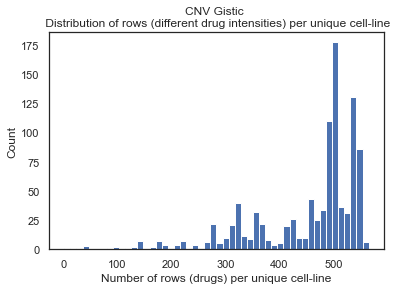

In [14]:
# CNV Gistic: Distribution of rows per unique cell-line.
plt.hist(final_cnv_gistic.groupby(['CELL_LINE_NAME']).size(), bins=50);
plt.xlabel('Number of rows (drugs) per unique cell-line');
plt.ylabel('Count');
plt.title('CNV Gistic \n Distribution of rows (different drug intensities) per unique cell-line');

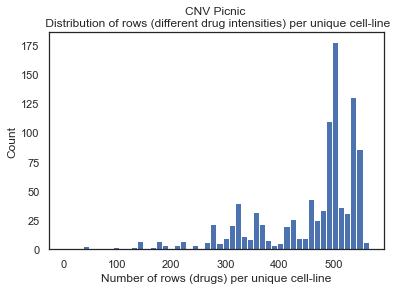

In [18]:
# CNV Gistic: Distribution of rows per unique cell-line.
plt.hist(final_cnv_picnic.groupby(['CELL_LINE_NAME']).size(), bins=50);
plt.xlabel('Number of rows (drugs) per unique cell-line');
plt.ylabel('Count');
plt.title('CNV Picnic \n Distribution of rows (different drug intensities) per unique cell-line');

In [8]:
# Distribution of copy numbers.

# Since all copy numbers per cell-line are identical, we can just investigate the 
# copy number values ofthe first row per unique cell-line.
gistic_unique_cell_lines = final_cnv_gistic.groupby(['CELL_LINE_NAME']).first()
picnic_unique_cell_lines = final_cnv_picnic.groupby(['CELL_LINE_NAME']).first()

copy_numbers_gistic = gistic_unique_cell_lines[gistic_unique_cell_lines.columns[14:]]
copy_numbers_picnic = picnic_unique_cell_lines[picnic_unique_cell_lines.columns[14:]]

print(copy_numbers_gistic.shape)
print(copy_numbers_picnic.shape)

(988, 937)
(988, 965)


In [23]:
from collections import Counter

copy_number_values_gistic = copy_numbers_gistic.values.tolist()[0]
copy_number_values_picnic = copy_numbers_picnic.values.tolist()[0]

gistic_cnvs_uniques = Counter(copy_number_values_gistic).keys()
gistic_cnvs_counts_per_uniq = Counter(copy_number_values_gistic).values()

picnic_cnvs_uniques = Counter(copy_number_values_picnic).keys()
picnic_cnvs_counts_per_uniq = Counter(copy_number_values_picnic).values()

print(f""" 
    Gistic
        unique copy numbers (cns) : {gistic_cnvs_uniques}
        count per uniq cn         : {gistic_cnvs_counts_per_uniq}

    Picnic
        unique copy numbers (cns) : {picnic_cnvs_uniques}
        count per uniq cn         : {picnic_cnvs_counts_per_uniq}        
""")

 
    Gistic
        unique copy numbers (cns) : dict_keys([1.0, -1.0, 0.0, 2.0, -2.0])
        count per uniq cn         : dict_values([423, 179, 324, 3, 8])

    Picnic
        unique copy numbers (cns) : dict_keys([4.0, 2.0, 3.0, 5.0, 11.0, 0.0, 6.0, 7.0, 1.0])
        count per uniq cn         : dict_values([289, 161, 456, 39, 1, 1, 8, 5, 5])        



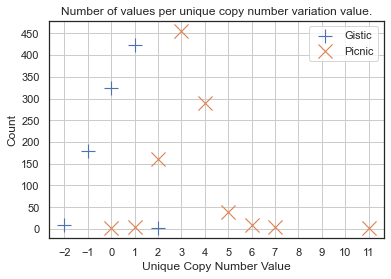

In [57]:
sns.scatterplot(x=list(gistic_cnvs_uniques),
                y=list(gistic_cnvs_counts_per_uniq), 
                marker='+', s=200, label='Gistic');
sns.scatterplot(x=list(picnic_cnvs_uniques),
                y=list(picnic_cnvs_counts_per_uniq), 
                marker='x', s=200, label='Picnic');
plt.xticks(np.arange(-2, 12, 1));
plt.yticks(np.arange(0, 500, 50));
plt.legend(markerscale=2)
plt.grid();
plt.legend();
plt.xlabel('Unique Copy Number Value');
plt.ylabel('Count');
plt.title('Number of values per unique copy number variation value.');     

In [74]:
gistic_df = pd.DataFrame({
    'unique_cn': list(gistic_cnvs_uniques),
    'counts': list(gistic_cnvs_counts_per_uniq)
})
gistic_df['perc_of_tot'] = round(100 * gistic_df.counts / gistic_df.counts.sum(), 2)
gistic_df = gistic_df.sort_values('perc_of_tot', ascending=False)
gistic_df['cum_perc_of_tot'] = gistic_df.perc_of_tot.cumsum()
gistic_df

,unique_cn,counts,perc_of_tot,cum_perc_of_tot
0,1.0,423,45.14,45.14
2,0.0,324,34.58,79.72
1,-1.0,179,19.10,98.82
4,-2.0,8,0.85,99.67
3,2.0,3,0.32,99.99


In [75]:
picnic_df = pd.DataFrame({
    'unique_cn': list(picnic_cnvs_uniques),
    'counts': list(picnic_cnvs_counts_per_uniq)
})
picnic_df['perc_of_tot'] = round(100 * picnic_df.counts / picnic_df.counts.sum(), 2)
picnic_df = picnic_df.sort_values('perc_of_tot', ascending=False)
picnic_df['cum_perc_of_tot'] = picnic_df.perc_of_tot.cumsum()
picnic_df

,unique_cn,counts,perc_of_tot,cum_perc_of_tot
2,3.0,456,47.25,47.25
0,4.0,289,29.95,77.20
1,2.0,161,16.68,93.88
3,5.0,39,4.04,97.92
6,6.0,8,0.83,98.75
7,7.0,5,0.52,99.27
8,1.0,5,0.52,99.79
4,11.0,1,0.10,99.89
5,0.0,1,0.10,99.99


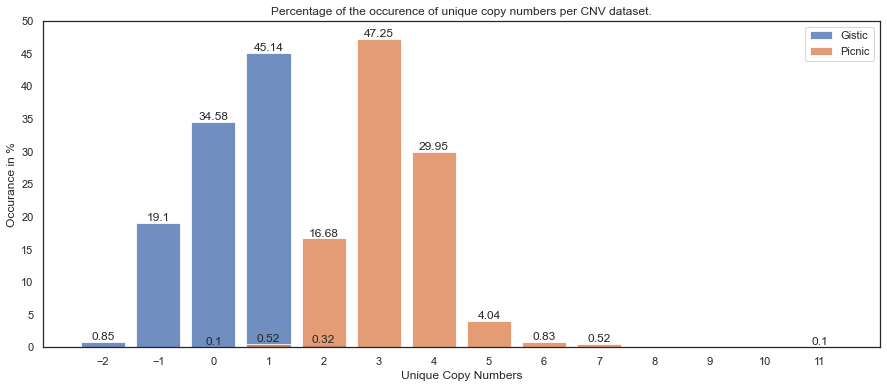

In [123]:
fig, ax = plt.subplots(figsize=(15,6))

p1 = ax.bar(x=gistic_df.unique_cn,
             height=gistic_df.perc_of_tot, alpha=0.8, label='Gistic');
p2 = ax.bar(x=picnic_df.unique_cn,
             height=picnic_df.perc_of_tot, alpha=0.8, label='Picnic');

ax.bar_label(p1);
ax.bar_label(p2);

ax.legend();
plt.xticks(np.arange(-2, 12, 1));    
plt.yticks(np.arange(0, 55, 5));   

plt.xlabel('Unique Copy Numbers');
plt.ylabel('Occurance in %');
plt.title('Percentage of the occurence of unique copy numbers per CNV dataset.');          

- The two CNV datasets _Gistic_ and _Picnic_ have very different unique copy number values. 
- _Gistic_: 
  - Has $5$ unique copy number values: `[1, -1, 0, 2, -2]`
  - Nearly all copy number values ($98.82$%) are one of `1, -1, 0`
- _Picnic_: 
  - Has $9$ unique copy number values: `[0, 1, 2, 3, 4, 5, 6, 7, 11]`
  - Nearly all copy number values ($93.88$%) are one of `3, 4, 2` 

In [19]:
final_cnv_picnic[final_cnv_picnic.CELL_LINE_NAME=='MC-CAR'].head(10)

,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,49,3137,2.0000,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
4563,49,3137,0.1000,MC-CAR,0.032311,0.980891,558232,683665,Rapamycin,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
8613,49,3137,8.0000,MC-CAR,0.023236,0.903979,333014,683665,Sunitinib,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
12843,49,3137,2.0000,MC-CAR,0.035483,0.986077,635581,683665,PHA-665752,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
17478,49,3137,1.0000,MC-CAR,0.039660,0.937027,423727,683665,MG-132,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
22257,49,3137,0.1024,MC-CAR,0.069014,0.728050,114576,683665,Paclitaxel,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
26496,49,3137,16.0000,MC-CAR,0.019343,0.978113,542783,683665,Cyclopamine,26,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
30987,49,3137,4.0000,MC-CAR,0.042844,0.945160,492276,683665,AZ628,26,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
35982,49,3137,4.0000,MC-CAR,0.024891,0.988067,607420,683665,Sorafenib,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
40680,49,3137,2.0000,MC-CAR,0.087602,0.897546,400968,683665,Tozasertib,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0


- Each cell-line (`CELL_LINE_NAME`) holds the same copy number variation data
  - The copy numbers differ only for different cell-line-drug combinations